Use the environment found on GCP at `/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm`

In [1]:
#enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload


In [2]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.model_selection import train_test_split
import random

# import from scfair-reproducibility
from scfair_reproducibility.benchmark_VAE.vi import VI
from scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker

# other methods
# import cpa
# from data.biolord_dev.src import biolord

/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]=""

In [4]:
from dis2pm.dis2pmPoissonvae import *
from dis2pm.dis2pmPoissonvi import *
from dis2pm.ood_m import *
from dis2pm.trainingplan_m import *
from dis2pm.utils_m import *

# prepare data: Neurips 2021 

https://openproblems.bio/events/2021-09_neurips/ 

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122


Data downloaded with `wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122%5Fopenproblems%5Fneurips2021%5Fmultiome%5FBMMC%5Fprocessed%2Eh5ad%2Egz`

Define function to convert covariate names to numerical values

In [5]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

Load and subsample the heart atlas dataset from Litvinukova et al. Nature 2020

In [6]:
adata = sc.read("/nfs/team205/sm58/packages/dis2p_trials/scfair/dis2pm_dev/data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
print(adata)

/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


In [7]:
print(adata.var["feature_types"].value_counts())

feature_types
ATAC    116490
GEX      13431
Name: count, dtype: int64


In [8]:
print(adata.obs["batch"].value_counts())

batch
s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: count, dtype: int64


In [9]:
print(adata.obs["DonorID"].value_counts())

DonorID
15078    18467
19593     9876
18303     8604
28483     6781
10886     6740
12710     6111
16710     4895
13272     4325
11466     1771
28045     1679
Name: count, dtype: int64


In [10]:

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
adata.raw = adata
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=1200,
#     subset=True,
#     layer="counts",
#     flavor="seurat_v3",
# )

# print(adata)
# print(adata[:,1198].X)
# adata_atac = adata[:, -200:].copy()
# adata_rna = adata[:, :1000].copy()
# adata_obs = adata.obs.copy()
# adata_uns = adata.uns.copy()
# adata_atac.X.data = np.ones(adata_atac.X.data.shape)
# adata = ad.concat([adata_rna, adata_atac], axis=1)
# adata.obs = adata_obs
# adata.uns = adata_uns
# print(adata[:,:].X.sum(axis=0))
# print(adata)

# specify name of dataset 
data_name = 'neurips2021'

# specify attributes
cats = ['DonorID', 'batch', 'Ethnicity']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [11]:
print(adata.var["feature_types"].value_counts())

feature_types
ATAC    116490
GEX      13431
Name: count, dtype: int64


# train model: dis2pm(n_cf=1)

In [12]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [16]:
# train params
epochs = 20 #400
batch_size = 256 #7 #128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2pmPoisson'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
# try:
#     model = Dis2pmVI.load(f"{pre_path}/{model_name}", adata=adata)

# # trains the model (if not trained before) and save it into: pre_path + model_name
# except:

Dis2pmPoissonVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
print(adata)
model = Dis2pmPoissonVI(adata, n_genes=13431, n_regions=116490, n_layers=n_layers)
model.train( **train_dict, plan_kwargs={'lr': 0.001},)
model.save(f"{pre_path}/{model_name}")

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'DonorID_idx', 'batch_idx', 'Ethnicity_idx', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_counts'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
13431
debug4
n_cats_per_cov is (10, 13, 2)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/sm58/packages/dis2p_trials/scfair/envs/dis2pm/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 20/20: 100%|█| 20/20 [47:03<00:00, 139.89s/it, v_num=1, loss_validation=3.62e+6, x_0_validation=4.34e+3, x_1_validation=4.43e+3, x_2_validation=4.45e+3, x_3_validation=4.42e+3, rec_x_cf_validation=5.19e+3, z_1_validation=4

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [47:03<00:00, 141.16s/it, v_num=1, loss_validation=3.62e+6, x_0_validation=4.34e+3, x_1_validation=4.43e+3, x_2_validation=4.45e+3, x_3_validation=4.42e+3, rec_x_cf_validation=5.19e+3, z_1_validation=4


In [10]:
# # n_layers=1
# # epochs = 50 #400
# # batch_size = 4 #128
# # cf_weight = 1
# # beta = 1
# # clf_weight = 50
# # adv_clf_weight = 10
# # adv_period = 1
# # n_cf = 1
# # n_genes=1000
# # n_regions=200

# n_latent_shared = 10
# n_input_regions = 200
# n_layers= 1 
# n_hidden=128 
# deeply_inject_covariates=True,
# use_batch_norm=True,
# use_layer_norm=False,
# n_cats_per_cov = (11, 4, 2, 6)

# x_decoder_acc =  DecoderPeakVI(
#                     n_latent_shared,
#                     n_input_regions,
#                     n_cat_list=n_cats_per_cov,
#                     n_layers=n_layers,
#                     n_hidden=n_hidden,
#                     deep_inject_covariates=deeply_inject_covariates,
#                     use_batch_norm=use_batch_norm,
#                     use_layer_norm=use_layer_norm,
#                 )
    
# idx=1
# x_=torch.tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
#           1.,  0.,  0.,  0.],
#         [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
#           0.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
#           0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
#           6.,  2.,  1.,  5.],
#         [ 0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
#           1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,
#           0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
#           0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,
#           1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
#           0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
#           0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
#           0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0., 10., 26., 38.,
#          34., 22., 14., 23.],
#         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
#           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
#           0.,  0.,  0.,  0.]] )


# cat_cov_ = torch.tensor( [[8., 0., 1., 2.],
#         [2., 2., 1., 1.],
#         [2., 0., 1., 2.],
#         [8., 3., 0., 4.]] )
# detach_x=False
# detach_z=False


# Dis2pmVI.setup_anndata(
#     adata,
#     layer='counts',
#     categorical_covariate_keys=cats,
#     continuous_covariate_keys=[]
# )

# # model = Dis2pmVI(adata, n_genes=1000, n_regions=200, n_layers=n_layers)

# model._module_cls.sub_forward_acc(idx=idx + 1, x=x_, cat_covs=cat_cov_)
# #model.Dis2pmVAE.sub_forward_acc(idx=idx + 1, x=x_, cat_covs=cat_cov_)


# n_cats_per_cov = (
#     self.adata_manager.get_state_registry(
#         REGISTRY_KEYS.CAT_COVS_KEY
#     ).n_cats_per_key
#     if REGISTRY_KEYS.CAT_COVS_KEY in self.adata_manager.data_registry
#     else None
# )
# # self.module = self._module_cls(
# #     #n_input_genes=self.summary_stats.n_vars,
# #     n_input_genes=n_genes,
# #     n_input_regions=n_regions,
# #     n_cats_per_cov=n_cats_per_cov,
# #     n_hidden=n_hidden,
# #     n_latent_shared=n_latent_shared,
# #     n_latent_attribute=n_latent_attribute,
# #     n_layers=n_layers,
# #     dropout_rate=dropout_rate,
# #     gene_likelihood=gene_likelihood,
# #     latent_distribution=latent_distribution,
# #     **model_kwargs,
# # # )


# # model1 = Dis2pmVAE(
# #         n_input_genes=n_genes,
# #     n_input_regions=n_regions,
# #     n_cats_per_cov=n_cats_per_cov,
# #     n_hidden=n_hidden,
# #     n_latent_shared=n_latent_shared,
# #     n_latent_attribute=n_latent_attribute,
# #     n_layers=n_layers,
# #     dropout_rate=dropout_rate,
# #     gene_likelihood=gene_likelihood,
# #     latent_distribution=latent_distribution,
# #     **model_kwargs,
# # )
    
# cat_covs =cat_cov_
# if detach_x:
#     x_ = x.detach()

# library = torch.ones(x_.size(dim=0) ) 

# cat_in = torch.split(cat_covs, 1, dim=1)

# qz, z = (self.z_encoders_list_acc[idx](x_, *cat_in))
# if detach_z:
#     z = z.detach()

# dec_cats = [cat_in[j] for j in range(len(cat_in)) if j != idx-1]

# x_decoder = x_decoder_acc

# px_scale, px_r, px_rate, px_dropout = x_decoder(
#     self.dispersion,
#     z,
#     library,
#     *dec_cats
# )     

# get latent space

In [11]:
# # load model
# pre_path = f'models/dis2pm'
# model_name = f'{today},dis2pm,HeartAtlas,n_layers=1,max_epochs=50,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
# model = Dis2pmVI.load(f"{pre_path}/{model_name}", adata=adata)

# # Z_0
# adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

# for i in range(len(cats)):
#     null_idx = [s for s in range(len(cats)) if s != i]
#     # Z_i
#     print(model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True))
#     adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
#     # Z_{-i}
#     print(  model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)  )
#     adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

# plot UMAP latent

In [12]:
# from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
# import warnings

# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [13]:
# for i in range(len(cats) + 1):  # loop over all Z_i

#     latent_name = f'dis2p_Z_{i}'

#     print(f"---UMAP for {latent_name}---")

#     sc.pp.neighbors(adata, use_rep=f"{latent_name}")
#     sc.tl.umap(adata)

#     sc.pl.umap(
#         adata,
#         color=cats,
#         ncols=len(cats),
#         frameon=False,
#     )

# Load previous model

In [14]:
today

'2023-12-06'

In [17]:
# # train params
# day = '2023-12-06'

# # train params
# epochs = 5 #400
# batch_size = 256 #7 #128
# cf_weight = 1
# beta = 1
# clf_weight = 50
# adv_clf_weight = 10
# adv_period = 1
# n_cf = 1

# # architecture params
# n_layers=1

# train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
#               'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
#               'adv_period': adv_period, 'n_cf': n_cf}

# module_name = 'dis2pmPoisson'
# pre_path = f'models/{module_name}'
# if not os.path.exists(pre_path):
#     os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())


dict_keys(['loss_validation', 'x_0_validation', 'x_1_validation', 'x_2_validation', 'x_3_validation', 'rec_x_cf_validation', 'z_1_validation', 'z_2_validation', 'z_3_validation', 'ce_validation', 'acc_validation', 'f1_validation', 'atac_0_validation', 'atac_1_validation', 'atac_2_validation', 'atac_3_validation', 'rec_x_cf_atac_validation', 'z_acc_1_validation', 'z_acc_2_validation', 'z_acc_3_validation', 'ce_atac_validation', 'acc_atac_validation', 'f1_atac_validation', 'adv_ce_validation', 'adv_acc_validation', 'adv_f1_validation', 'adv_ce_atac_validation', 'adv_acc_atac_validation', 'adv_f1_atac_validation', 'loss_train', 'x_0_train', 'x_1_train', 'x_2_train', 'x_3_train', 'rec_x_cf_train', 'z_1_train', 'z_2_train', 'z_3_train', 'ce_train', 'acc_train', 'f1_train', 'atac_0_train', 'atac_1_train', 'atac_2_train', 'atac_3_train', 'rec_x_cf_atac_train', 'z_acc_1_train', 'z_acc_2_train', 'z_acc_3_train', 'ce_atac_train', 'acc_atac_train', 'f1_atac_train', 'adv_ce_train', 'adv_acc_train'

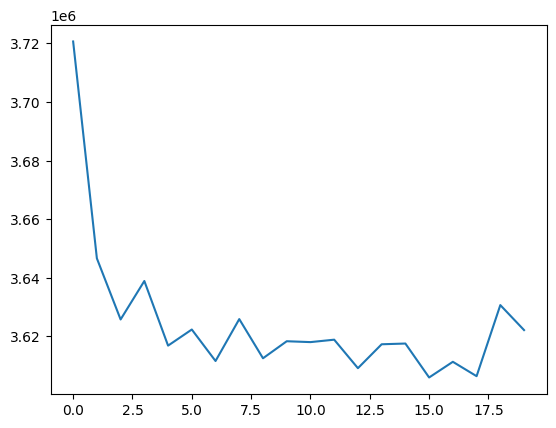

In [18]:
import matplotlib.pyplot as plt 
print(model.history.keys())

plt.plot(model.history['loss_validation'])


In [19]:
#plt.plot(model.history['loss_validation'])
print(model.history.keys())

dict_keys(['loss_validation', 'x_0_validation', 'x_1_validation', 'x_2_validation', 'x_3_validation', 'rec_x_cf_validation', 'z_1_validation', 'z_2_validation', 'z_3_validation', 'ce_validation', 'acc_validation', 'f1_validation', 'atac_0_validation', 'atac_1_validation', 'atac_2_validation', 'atac_3_validation', 'rec_x_cf_atac_validation', 'z_acc_1_validation', 'z_acc_2_validation', 'z_acc_3_validation', 'ce_atac_validation', 'acc_atac_validation', 'f1_atac_validation', 'adv_ce_validation', 'adv_acc_validation', 'adv_f1_validation', 'adv_ce_atac_validation', 'adv_acc_atac_validation', 'adv_f1_atac_validation', 'loss_train', 'x_0_train', 'x_1_train', 'x_2_train', 'x_3_train', 'rec_x_cf_train', 'z_1_train', 'z_2_train', 'z_3_train', 'ce_train', 'acc_train', 'f1_train', 'atac_0_train', 'atac_1_train', 'atac_2_train', 'atac_3_train', 'rec_x_cf_atac_train', 'z_acc_1_train', 'z_acc_2_train', 'z_acc_3_train', 'ce_atac_train', 'acc_atac_train', 'f1_atac_train', 'adv_ce_train', 'adv_acc_train'

In [20]:
for i in model.history.keys():
    print(i)

loss_validation
x_0_validation
x_1_validation
x_2_validation
x_3_validation
rec_x_cf_validation
z_1_validation
z_2_validation
z_3_validation
ce_validation
acc_validation
f1_validation
atac_0_validation
atac_1_validation
atac_2_validation
atac_3_validation
rec_x_cf_atac_validation
z_acc_1_validation
z_acc_2_validation
z_acc_3_validation
ce_atac_validation
acc_atac_validation
f1_atac_validation
adv_ce_validation
adv_acc_validation
adv_f1_validation
adv_ce_atac_validation
adv_acc_atac_validation
adv_f1_atac_validation
loss_train
x_0_train
x_1_train
x_2_train
x_3_train
rec_x_cf_train
z_1_train
z_2_train
z_3_train
ce_train
acc_train
f1_train
atac_0_train
atac_1_train
atac_2_train
atac_3_train
rec_x_cf_atac_train
z_acc_1_train
z_acc_2_train
z_acc_3_train
ce_atac_train
acc_atac_train
f1_atac_train
adv_ce_train
adv_acc_train
adv_f1_train
adv_ce_atac_train
adv_acc_atac_train
adv_f1_atac_train


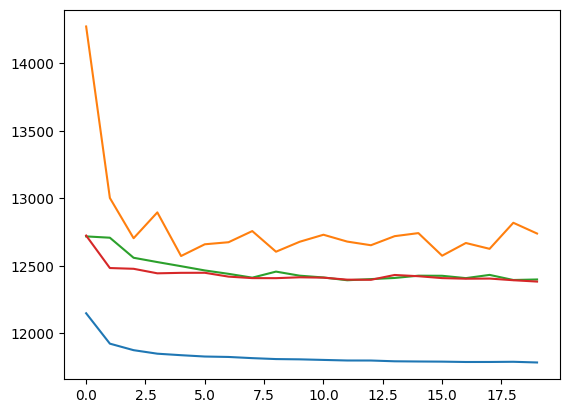

In [22]:
plt.plot(model.history['atac_0_validation'])
plt.plot(model.history['atac_1_validation'])
plt.plot(model.history['atac_2_validation'])
plt.plot(model.history['atac_3_validation'])


In [ ]:
# load model

# Z_0
adata.obsm[f'dis2p_Z_0_gex'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)["GEX"] 
adata.obsm[f'dis2p_Z_0_atac'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)["ATAC"] 

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}_gex'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)['GEX']
    adata.obsm[f'dis2p_Z_{i+1}_atac'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)['ATAC']
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}_gex'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)['GEX']    
    adata.obsm[f'dis2p_Z_not_{i+1}_atac'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)['ATAC']

In [ ]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)


In [ ]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}_gex'

    print(f"---UMAP for {latent_name} ---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

In [ ]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}_atac'

    print(f"---UMAP for {latent_name} ---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )